# Transformers for Sentiment Analysis

+++ This notebook is adapted from transformers notebook in https://github.com/bentrevett/pytorch-sentiment-analysis +++
____________

In this notebook we will be using the transformer model, first introduced in [this](https://arxiv.org/abs/1706.03762) paper. Specifically, we will be using the BERT (Bidirectional Encoder Representations from Transformers) model from [this](https://arxiv.org/abs/1810.04805) paper. 

Transformer models are considerably larger than anything else covered in these tutorials. As such we are going to use the [transformers library](https://github.com/huggingface/transformers) to get pre-trained transformers and use them as our embedding layers. We will freeze (not train) the transformer and only train the remainder of the model which learns from the representations produced by the transformer. In this case we will be using a multi-layer bi-directional GRU, however any model can learn from these representations.

## Preparing Data

First, as always, let's set the random seeds for deterministic results.

In [1]:
%pip install torch transformers torchtext

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch

import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

The transformer has already been trained with a specific vocabulary, which means we need to train with the exact same vocabulary and also tokenize our data in the same way that the transformer did when it was initially trained.

Luckily, the transformers library has tokenizers for each of the transformer models provided. In this case we are using the BERT model which ignores casing (i.e. will lower case every word). We get this by loading the pre-trained `bert-base-uncased` tokenizer.

In [3]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

The `tokenizer` has a `vocab` attribute which contains the actual vocabulary we will be using. We can check how many tokens are in it by checking its length.

In [4]:
len(tokenizer.vocab)

30522

Using the tokenizer is as simple as calling `tokenizer.tokenize` on a string. This will tokenize and lower case the data in a way that is consistent with the pre-trained transformer model.

In [5]:
tokens = tokenizer.tokenize('Hello WORLD how ARE yoU?')

print(tokens)

['hello', 'world', 'how', 'are', 'you', '?']


We can numericalize tokens using our vocabulary using `tokenizer.convert_tokens_to_ids`.

In [6]:
indexes = tokenizer.convert_tokens_to_ids(tokens)

print(indexes)

[7592, 2088, 2129, 2024, 2017, 1029]


The transformer was also trained with special tokens to mark the beginning and end of the sentence, detailed [here](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel). As well as a standard padding and unknown token. We can also get these from the tokenizer.

**Note**: the tokenizer does have a beginning of sequence and end of sequence attributes (`bos_token` and `eos_token`) but these are not set and should not be used for this transformer.

In [7]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


We can get the indexes of the special tokens by converting them using the vocabulary...

In [8]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


...or by explicitly getting them from the tokenizer.

In [9]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


Another thing we need to handle is that the model was trained on sequences with a defined maximum length - it does not know how to handle sequences longer than it has been trained on. We can get the maximum length of these input sizes by checking the `max_model_input_sizes` for the version of the transformer we want to use. In this case, it is 512 tokens.

In [10]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

print(max_input_length)

512


Previously we have used the `spaCy` tokenizer to tokenize our examples. However we now need to define a function that we will pass to our `TEXT` field that will handle all the tokenization for us. It will also cut down the number of tokens to a maximum length. Note that our maximum length is 2 less than the actual maximum length. This is because we need to append two tokens to each sequence, one to the start and one to the end.

In [11]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

Now we define our fields. The transformer expects the batch dimension to be first, so we set `batch_first = True`. As we already have the vocabulary for our text, provided by the transformer we set `use_vocab = False` to tell torchtext that we'll be handling the vocabulary side of things. We pass our `tokenize_and_cut` function as the tokenizer. The `preprocessing` argument is a function that takes in the example after it has been tokenized, this is where we will convert the tokens to their indexes. Finally, we define the special tokens - making note that we are defining them to be their index value and not their string value, i.e. `100` instead of `[UNK]` This is because the sequences will already be converted into indexes.

We define the label field as before.

In [12]:
from torchtext import data

TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(dtype = torch.float)

/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


We load the data and create the validation splits as before.

In [13]:
from torchtext import datasets

### train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
mpqa_sentiment_dataset = data.TabularDataset(
    path='data/mpqa/all-bcbfeed8.tsv', format='tsv',
    fields=(
        ('text', TEXT), 
        ('label', LABEL)
    ),
    skip_header=True
)
train_data, test_data = mpqa_sentiment_dataset.split()

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


We can check an example and ensure that the text has already been numericalized.

In [14]:
print(vars(train_data.examples[3]))

{'text': [2009, 4150, 1010, 1999, 1037, 6881, 2126, 1010, 2625, 21668], 'label': 'neg'}


We can use the `convert_ids_to_tokens` to transform these indexes back into readable tokens.

In [15]:
tokens = tokenizer.convert_ids_to_tokens(vars(train_data.examples[3])['text'])

print(tokens)

['it', 'becomes', ',', 'in', 'a', 'weird', 'way', ',', 'less', 'monstrous']


In [16]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 5197
Number of validation examples: 2227
Number of testing examples: 3182


Although we've handled the vocabulary for the text, we still need to build the vocabulary for the labels.

In [17]:
LABEL.build_vocab(train_data)

In [18]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


As before, we create the iterators. Ideally we want to use the largest batch size that we can as I've found this gives the best results for transformers.

In [19]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Since we do not use a standard dataset but a custom one, this
# might cause problems such as a CUDNN_STATUS_EXECUTION_FAILED 
# error. Changes a made here: *
# https://github.com/pytorch/text/issues/474
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort=False   # *
)

/opt/conda/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Build the Model

Next, we'll load the pre-trained model, making sure to load the same model as we did for the tokenizer.

In [20]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

Next, we'll define our actual model. 

Instead of using an embedding layer to get embeddings for our text, we'll be using the pre-trained transformer model. These embeddings will then be fed into a GRU to produce a prediction for the sentiment of the input sentence. We get the embedding dimension size (called the `hidden_size`) from the transformer via its config attribute. The rest of the initialization is standard.

Within the forward pass, we wrap the transformer in a `no_grad` to ensure no gradients are calculated over this part of the model. The transformer actually returns the embeddings for the whole sequence as well as a *pooled* output. The [documentation](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel) states that the pooled output is "usually not a good summary of the semantic content of the input, you’re often better with averaging or pooling the sequence of hidden-states for the whole input sequence", hence we will not be using it. The rest of the forward pass is the standard implementation of a recurrent model, where we take the hidden state over the final time-step, and pass it through a linear layer to get our predictions.

In [21]:
from bert_gru_sentiment import BERTGRUSentiment

Next, we create an instance of our model using standard hyperparameters.

In [22]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

We can check how many parameters the model has. The standard models from the tutorial have under 5M, but this one has 112M! Luckily, 110M of these parameters are from the transformer and we will not be training those.

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 112,241,409 trainable parameters


In order to freeze paramers (not train them) we need to set their `requires_grad` attribute to `False`. To do this, we simply loop through all of the `named_parameters` in our model and if they're a part of the `bert` transformer model, we set `requires_grad = False`. 

In [24]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

We can now see that our model has under 3M trainable parameters, making it almost comparable to the `FastText` model. However, the text still has to propagate through the transformer which causes training to take considerably longer.

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,759,169 trainable parameters


We can double check the names of the trainable parameters, ensuring they make sense. As we can see, they are all the parameters of the GRU (`rnn`) and the linear layer (`out`).

In [26]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out.weight
out.bias


## Train the Model

As is standard, we define our optimizer and criterion (loss function).

In [27]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [28]:
from torch import nn
criterion = nn.BCEWithLogitsLoss()

Place the model and criterion onto the GPU (if available)

In [29]:
model = model.to(device)
criterion = criterion.to(device)

Next, we'll define functions for: calculating accuracy, performing a training epoch, performing an evaluation epoch and calculating how long a training/evaluation epoch takes.

In [30]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [31]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [32]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [33]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we'll train our model. This takes considerably longer than any of the previous models due to the size of the transformer. Even though we are not training any of the transformer's parameters we still need to pass the data through the model which takes a considerable amount of time on a standard GPU.

In [4]:
MODEL_OUTPUT_FILENAME = 'output/opinion_polarity/BERTGRUSentiment-model-MPQA_v2_100.pt'

In [35]:
performance_data = {
    'Epoch': [], 
    'Train Loss': [],
    'Train Acc': [],
    'Val. Loss': [],
    'Val. Acc': [],
    'Epoch Time elapsed': []
}

In [36]:
import torch

In [58]:
N_EPOCHS = 500

best_valid_loss = float('inf')


for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_OUTPUT_FILENAME)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    performance_data['Epoch'].append(epoch)
    performance_data['Train Loss'].append(train_loss)
    performance_data['Train Acc'].append(train_acc*100)
    performance_data['Val. Loss'].append(valid_loss)
    performance_data['Val. Acc'].append(valid_acc*100)
    performance_data['Epoch Time elapsed'].append(end_time - start_time)
    
#torch.backends.cudnn.version()
#torch.backends.cudnn.enabled = True

/opt/conda/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.070 | Train Acc: 96.78%
	 Val. Loss: 0.544 |  Val. Acc: 88.19%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.073 | Train Acc: 97.04%
	 Val. Loss: 0.503 |  Val. Acc: 87.54%
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.068 | Train Acc: 97.09%
	 Val. Loss: 0.547 |  Val. Acc: 87.48%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.066 | Train Acc: 97.32%
	 Val. Loss: 0.549 |  Val. Acc: 87.37%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.073 | Train Acc: 96.90%
	 Val. Loss: 0.521 |  Val. Acc: 87.52%
Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.075 | Train Acc: 97.12%
	 Val. Loss: 0.509 |  Val. Acc: 87.39%
Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.072 | Train Acc: 97.02%
	 Val. Loss: 0.515 |  Val. Acc: 87.69%
Epoch: 08 | Epoch Time: 0m 5s
	Train Loss: 0.064 | Train Acc: 97.54%
	 Val. Loss: 0.560 |  Val. Acc: 87.11%
Epoch: 09 | Epoch Time: 0m 5s
	Train Loss: 0.062 | Train Acc: 97.32%
	 Val. Loss: 0.583 |  Val. Acc: 87.58%
Epoch: 10 | Epoch Time: 0m 5

In [59]:
import pandas as pd 
performance_df = pd.DataFrame.from_dict(performance_data)
performance_df = performance_df.set_index('Epoch')
performance_df.to_csv(path_or_buf=f'{MODEL_OUTPUT_FILENAME}_result.csv')
performance_df

,Train Loss,Train Acc,Val. Loss,Val. Acc,Epoch Time elapsed
Epoch,,,,,
0,0.576698,70.721066,0.386551,82.462725,4.865226
1,0.405422,82.076784,0.338668,85.654106,4.999137
2,0.351576,84.598214,0.308255,87.194479,4.874531
3,0.318866,86.433669,0.298047,87.628506,4.981327
4,0.312140,86.948398,0.293364,88.128064,5.030830
...,...,...,...,...,...
495,0.033017,98.482044,0.825533,88.105086,5.395586
496,0.037358,98.253385,0.740406,87.605528,5.383445
497,0.036313,98.386769,0.751093,87.562126,5.327579


In [23]:
import pandas as pd
performance_df = pd.read_csv(f'{MODEL_OUTPUT_FILENAME}_result.csv')

In [24]:
performance_df.head()

,Epoch,Train Loss,Train Acc,Val. Loss,Val. Acc,Epoch Time elapsed
0,0,0.576698,70.721066,0.386551,82.462725,4.865226
1,1,0.405422,82.076784,0.338668,85.654106,4.999137
2,2,0.351576,84.598214,0.308255,87.194479,4.874531
3,3,0.318866,86.433669,0.298047,87.628506,4.981327
4,4,0.312140,86.948398,0.293364,88.128064,5.030830


In [25]:
performance_df.set_index('Epoch',drop=True, inplace=True)

In [26]:
performance_df = performance_df[~performance_df.index.duplicated(keep='first')]
performance_df

,Train Loss,Train Acc,Val. Loss,Val. Acc,Epoch Time elapsed
Epoch,,,,,
0,0.576698,70.721066,0.386551,82.462725,4.865226
1,0.405422,82.076784,0.338668,85.654106,4.999137
2,0.351576,84.598214,0.308255,87.194479,4.874531
3,0.318866,86.433669,0.298047,87.628506,4.981327
4,0.312140,86.948398,0.293364,88.128064,5.030830
...,...,...,...,...,...
495,0.033017,98.482044,0.825533,88.105086,5.395586
496,0.037358,98.253385,0.740406,87.605528,5.383445
497,0.036313,98.386769,0.751093,87.562126,5.327579


In [27]:
performance_df.describe()

,Train Loss,Train Acc,Val. Loss,Val. Acc,Epoch Time elapsed
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.057330,97.518085,0.681153,87.359120,5.403847
std,0.051098,2.238968,0.116505,0.600540,0.103120
min,0.027469,70.721066,0.293364,82.462725,4.865226
25%,0.036439,97.827744,0.648118,87.084482,5.367186
50%,0.040862,98.183600,0.716348,87.431917,5.411764
75%,0.049850,98.369323,0.758075,87.735737,5.453374
max,0.576698,98.894817,0.904434,88.431032,5.654510


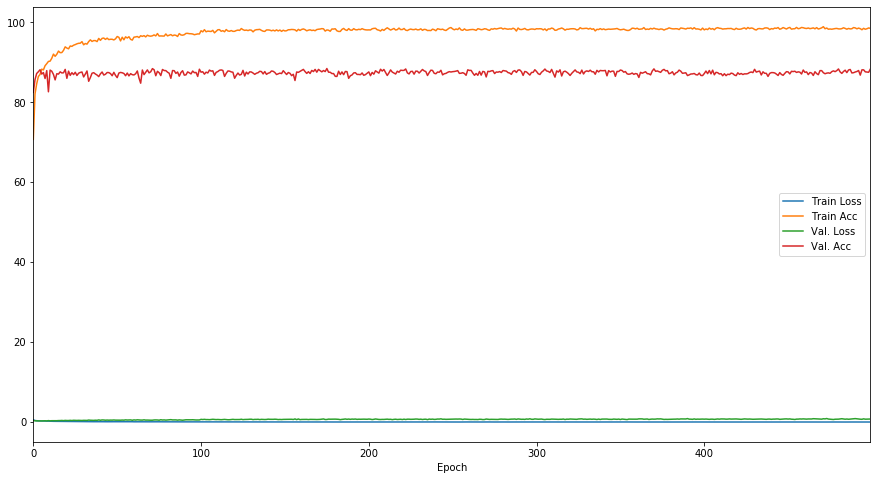

In [31]:
performance_df[['Train Loss','Train Acc','Val. Loss','Val. Acc']].plot(figsize=(15,8)).figure.savefig('output/opinion_polarity/opinion_polarity_training.svg')

We'll load up the parameters that gave us the best validation loss and try these on the test set - which gives us our best results so far!

In [ ]:
import torch

In [43]:
model.load_state_dict(torch.load(MODEL_OUTPUT_FILENAME))

<All keys matched successfully>

In [44]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/opt/conda/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Test Loss: 0.288 | Test Acc: 88.82%


## Inference

We'll then use the model to test the sentiment of some sequences. We tokenize the input sequence, trim it down to the maximum length, add the special tokens to either side, convert it to a tensor, add a fake batch dimension and then pass it through our model.

In [45]:
def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [46]:
predict_sentiment(model, tokenizer, "This film is terrible") # ~ 0.02264 after IMDB training

0.004528311546891928

In [51]:
predict_sentiment(model, tokenizer, "This film is great") # ~ 0.94110 after IMDB training

0.4945968687534332

In [52]:
predict_sentiment(model, tokenizer, "it’s amazing how our city loves him") # ~ 0.94110 after IMDB training

0.3239787817001343

In [48]:
# https://www.bbc.com/news/world-us-canada-53293542

predict_sentiment(model, tokenizer, '''
US President Donald Trump has used an Independence Day address to vow to defeat the "radical left" as protests sweep the country.

Striking a combative tone, Mr Trump said he would "fight... to preserve American way of life", while railing at "mobs" targeting historical monuments.

Ahead of his speech, Black Lives Matter protesters gathered nearby.

Mr Trump's 2020 election rival Joe Biden said everyone deserved "a full share of the American dream".

The 4 July holiday marks the nation's declaration of independence from Britain in 1776 and is one of the most important days in the national calendar.

Historically presidents have used the occasion to deliver speeches extolling the virtues of unity. Last year Mr Trump spoke of the "extraordinary heritage" of the country at an event with a militaristic theme that involved Air Force flyovers and tanks parked on display.

This year, Mr Trump's address was again followed by a flyover involving various aircraft, including B-52 bombers and F-35 fighter jets.''')

0.10930893570184708